In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
import torch.nn.functional as F
from scipy.fftpack import fft
import numpy as np
from sklearn.model_selection import KFold

In [3]:
# Load them up
fitted_wc = np.load("../outputs/results/basic_fit/wc_curves.npy")
fitted_lc = np.load("../outputs/results/basic_fit/lc_curves.npy")
gt_df = pd.read_csv("../outputs/train_labels.csv")
gt_df = gt_df.iloc[:, ::-1]  # rememver to reverse the columns - bloody hell
gt_df = gt_df.to_numpy()
airs = np.load("../data/processed/kaggle_sub_processed/airs_v4.npy")
airs = airs.sum(axis=3)  # sum over spatial dimension

In [4]:
wc_ratio = np.load("../outputs/results/basic_fit/wc_ratio.npy")

Generate training and validation indices ----->

In [5]:
train_labels = pd.read_csv("../data/raw/train_labels.csv")
star_labels = pd.read_csv("../data/raw/train_adc_info.csv")
# the train data is aligned with the star data
sum(train_labels.planet_id != star_labels.planet_id)

0

In [6]:
def generate_indices(star_types, k_folds=5, unseen_prop=0.7, random_state=None):
    indices_star_type_0 = np.where(star_types == 1)[0]
    indices_star_type_1 = np.where(star_types == 0)[0]

    kf = KFold(n_splits=k_folds, shuffle=True, random_state=random_state)

    train_indices_list = []
    val_indices_list = []

    for train_index, val_index in kf.split(indices_star_type_0):
        # Training indices for star type 0
        train_indices = indices_star_type_0[train_index]

        # Validation indices for star type 0 (OOF)
        val_indices_oof = indices_star_type_0[val_index]

        # Random sampling of star type 1 for validation
        val_indices_star_type_1 = np.random.choice(
            indices_star_type_1,
            size=int(len(val_indices_oof) * unseen_prop),
            replace=False,
        )

        # Combine validation indices
        val_indices = np.concatenate(
            [val_indices_oof, val_indices_star_type_1])

        train_indices_list.append(train_indices)
        val_indices_list.append(val_indices)

    return train_indices_list, val_indices_list


# Example usage
star_types = star_labels.star
train_indices_list, val_indices_list = generate_indices(
    star_types, k_folds=3, random_state=42
)

In [7]:
def compute_spectral_density(signal):
    # Perform the Fast Fourier Transform (FFT)
    fft_values = np.fft.fft(signal)

    # Calculate the Power Spectral Density
    psd = np.abs(fft_values) ** 2 / len(signal)

    return psd

In [8]:
# data input to our model
normalized_wc = fitted_wc / fitted_wc[:, :10].mean(axis=1, keepdims=True)
normalized_lc = fitted_lc / fitted_lc[:, :10, :].mean(axis=1, keepdims=True)
normalized_airs = airs / airs[:, :10].mean(axis=1, keepdims=True)

mean_wc = normalized_wc.mean(axis=1, keepdims=True)
mean_lc = normalized_lc.mean(axis=1, keepdims=True)
mean_airs = airs.mean(axis=1, keepdims=True)

demeaned_wc = normalized_wc - mean_wc
demeaned_lc = normalized_lc - mean_lc
demeaned_airs = airs - mean_airs

psd_lc = compute_spectral_density(demeaned_lc)
psd_airs = compute_spectral_density(demeaned_airs)

normalized_psd_lc = psd_lc / np.percentile(psd_lc, 95, axis=1, keepdims=True)
normalized_psd_airs = psd_airs / \
    np.percentile(psd_airs, 95, axis=1, keepdims=True)

In [9]:
mean_gt = gt_df[:, :-2] - gt_df[:, :-2].mean(axis=1, keepdims=True)

In [10]:
norm_gt_df = mean_gt

In [11]:
import torch

import torch.nn as nn
import torch.nn.functional as F


class SimpleCNN_RNN_Model(nn.Module):
    def __init__(self, time_steps, n_frequencies, hidden_size=64, num_layers=2):
        super(SimpleCNN_RNN_Model, self).__init__()

        # Convolutional layers for time series data
        self.conv1 = nn.Conv2d(
            in_channels=2, out_channels=32, kernel_size=(5, 3), stride=(1, 1))
        self.conv2 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=(3, 5), stride=(1, 1))
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))
        self.dropout = nn.Dropout(p=0.5)

        # Calculate the output dimensions after convolution and pooling
        dummy_input = torch.zeros(1, 2, time_steps, n_frequencies)
        conv_output_shape = self._get_conv_output(dummy_input)

        # Bidirectional LSTM for sequential learning
        self.lstm = nn.LSTM(input_size=conv_output_shape[2], hidden_size=hidden_size,
                            batch_first=True, num_layers=num_layers, bidirectional=True)

        # Fully connected layers for final prediction
        # Multiply by 2 for bidirectional LSTM
        self.fc1 = nn.Linear(hidden_size * 2, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, n_frequencies)

    def _get_conv_output(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # Output as (batch, time_steps, features)
        return x.view(x.size(0), x.size(2), -1).shape

    def forward(self, x_clean, x_raw):
        # Combine cleaned and raw time series data as two channels
        x_combined = torch.stack((x_clean, x_raw), dim=1)

        # Apply convolutional layers to combined time series data
        x_combined = self.pool(F.relu(self.conv1(x_combined)))
        x_combined = self.pool(F.relu(self.conv2(x_combined)))
        x_combined = self.dropout(x_combined)

        # Reshape for LSTM input
        # (batch_size, new_time_steps, new_features)
        x_combined = x_combined.view(
            x_combined.size(0), x_combined.size(2), -1)

        # Bidirectional LSTM layer
        x_combined, _ = self.lstm(x_combined)

        # Use the output of the last LSTM time step
        x_combined = x_combined[:, -1, :]

        # Fully connected layers for final prediction
        x = F.relu(self.fc1(x_combined))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x


# Example usage
model = SimpleCNN_RNN_Model(time_steps=187, n_frequencies=282)
# Batch of 16, 187 time steps, 282 frequencies (cleaned data)
example_clean = torch.randn(16, 187, 282)
# Batch of 16, 187 time steps, 282 frequencies (raw data)
example_raw = torch.randn(16, 187, 282)
output = model(example_clean, example_raw)
print(output.shape)  # Should be (16, 282)


class CNN_RNN_Model(nn.Module):
    def __init__(self, time_steps, n_frequencies, hidden_size=64, num_layers=2):
        super(CNN_RNN_Model, self).__init__()

        # Convolutional layers for cleaned and raw time series data
        self.conv1 = nn.Conv2d(
            in_channels=2, out_channels=32, kernel_size=(5, 3), stride=(1, 1)
        )
        self.conv2 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=(3, 5), stride=(1, 1)
        )
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv3 = nn.Conv2d(
            in_channels=64, out_channels=128, kernel_size=(3, 3), stride=(1, 1)
        )
        self.conv4 = nn.Conv2d(
            in_channels=128, out_channels=256, kernel_size=(3, 3), stride=(1, 1)
        )
        self.conv5 = nn.Conv2d(
            in_channels=256, out_channels=512, kernel_size=(3, 3), stride=(1, 1)
        )
        self.dropout = nn.Dropout(p=0.5)

        # Calculate the output dimensions after convolution and pooling
        dummy_input = torch.zeros(1, 2, time_steps, n_frequencies)
        conv_output_shape = self._get_conv_output(dummy_input)

        # Bidirectional LSTM for sequential learning
        self.lstm = nn.LSTM(
            input_size=conv_output_shape[2],
            hidden_size=hidden_size,
            batch_first=True,
            num_layers=num_layers,
            bidirectional=True,
        )

        # Convolutional layers for PSD data
        self.conv_psd1 = nn.Conv2d(
            in_channels=1,
            out_channels=32,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.conv_psd2 = nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.pool_psd = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv_psd3 = nn.Conv2d(
            in_channels=64,
            out_channels=128,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.conv_psd4 = nn.Conv2d(
            in_channels=128,
            out_channels=256,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )

        # Calculate the output dimensions after convolution and pooling for PSD data
        dummy_psd_input = torch.zeros(1, 1, time_steps, n_frequencies)
        psd_output_shape = self._get_psd_conv_output(dummy_psd_input)

        # Fully connected layers for final prediction
        self.fc1 = nn.Linear(
            hidden_size * 2  # Multiply by 2 for bidirectional LSTM
            + psd_output_shape[1] * psd_output_shape[2] * psd_output_shape[3],
            256,
        )
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, n_frequencies)

    def _get_conv_output(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        x = F.relu(self.conv5(x))
        return x.view(
            x.size(0), x.size(2), -1
        ).shape  # Output as (batch, time_steps, features)

    def _get_psd_conv_output(self, x):
        x = self.pool_psd(F.relu(self.conv_psd1(x)))
        x = self.pool_psd(F.relu(self.conv_psd2(x)))
        x = F.relu(self.conv_psd3(x))
        x = self.pool_psd(F.relu(self.conv_psd4(x)))
        return x.shape  # Output shape

    def forward(self, x_clean, x_raw, x_psd):
        # Combine cleaned and raw time series data as two channels
        x_combined = torch.stack((x_clean, x_raw), dim=1)

        # Apply convolutional layers to combined time series data
        x_combined = self.pool(F.relu(self.conv1(x_combined)))
        x_combined = self.pool(F.relu(self.conv2(x_combined)))
        x_combined = F.relu(self.conv3(x_combined))
        x_combined = self.pool(F.relu(self.conv4(x_combined)))
        x_combined = F.relu(self.conv5(x_combined))
        x_combined = self.dropout(x_combined)

        # Reshape for LSTM input
        x_combined = x_combined.view(
            x_combined.size(0), x_combined.size(2), -1
        )  # (batch_size, new_time_steps, new_features)

        # Bidirectional LSTM layer
        x_combined, _ = self.lstm(x_combined)

        # Use the output of the last LSTM time step
        x_combined = x_combined[:, -1, :]

        # Apply convolutional layers to PSD data
        x_psd = x_psd.unsqueeze(1)  # Add a channel dimension
        x_psd = self.pool_psd(F.relu(self.conv_psd1(x_psd)))
        x_psd = self.pool_psd(F.relu(self.conv_psd2(x_psd)))
        x_psd = F.relu(self.conv_psd3(x_psd))
        x_psd = self.pool_psd(F.relu(self.conv_psd4(x_psd)))
        x_psd = x_psd.view(x_psd.size(0), -1)  # Flatten
        x_psd = self.dropout(x_psd)

        # Concatenate features from both branches
        x = torch.cat((x_combined, x_psd), dim=1)

        # Fully connected layers for final prediction
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x


# Example usage
model = CNN_RNN_Model(time_steps=187, n_frequencies=282)
example_clean = torch.randn(
    16, 187, 282
)  # Batch of 16, 187 time steps, 283 frequencies (cleaned data)
example_raw = torch.randn(
    16, 187, 282
)  # Batch of 16, 187 time steps, 283 frequencies (raw data)
example_psd = torch.randn(
    16, 187, 282
)  # Batch of 16, 187 time steps, 283 frequencies (PSD data)
# output = model(example_clean, example_raw, example_psd)
print(output.shape)  # Should be (16, 283)

torch.Size([16, 282])
torch.Size([16, 282])


In [12]:
model

CNN_RNN_Model(
  (conv1): Conv2d(2, 32, kernel_size=(5, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (dropout): Dropout(p=0.5, inplace=False)
  (lstm): LSTM(15360, 64, num_layers=2, batch_first=True, bidirectional=True)
  (conv_psd1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_psd2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool_psd): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv_psd3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_psd4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=206208,

In [13]:
# Create DataLoader
example_clean = torch.from_numpy(normalized_lc).float()
example_raw = torch.from_numpy(normalized_airs).float()
example_psd = torch.from_numpy(normalized_psd_lc).float()
# targets = torch.from_numpy(gt_df[:, :-2]).float()
targets = torch.from_numpy(norm_gt_df*1000).float()

In [14]:
# output = model(example_clean, example_raw, example_psd)
# print(output.shape)  # Should be (16, 283)

In [15]:
# Create DataLoader
# dataset = TensorDataset(example_clean, example_raw, example_psd, targets)
dataset = TensorDataset(example_clean, example_raw, example_psd, targets)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move model to the same device as the data
model.to(device)
# Define loss function and optimizer
# criterion = nn.L1Loss()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Early stopping parameters
patience = 3
best_val_loss = float("inf")
patience_counter = 10

# Training loop
num_epochs = 100
# k_folds = len(train_indices_list)
k_folds = 1
for fold in range(k_folds):
    print(f"Fold {fold+1}/{k_folds}")

    train_indices = train_indices_list[fold]
    val_indices = val_indices_list[fold]

    # Create DataLoader for training and validation sets
    train_subset = Subset(
        TensorDataset(example_clean, example_raw,
                      example_psd, targets), train_indices
    )
    val_subset = Subset(
        TensorDataset(example_clean, example_raw,
                      example_psd, targets), val_indices
    )
    train_loader = DataLoader(train_subset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=16, shuffle=False)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (x_clean, x_raw, x_psd, target) in enumerate(train_loader):
            # Move data to the same device as the model
            x_clean, x_raw, x_psd, target = (
                x_clean.to(device),
                x_raw.to(device),
                x_psd.to(device),
                target.to(device),
            )

            optimizer.zero_grad()
            outputs = model(x_clean, x_raw, x_psd)  # model(x_clean, x_raw)  #
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        print(
            f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.8f}")

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for i, (x_clean, x_raw, x_psd, target) in enumerate(val_loader):
                x_clean, x_raw, x_psd, target = (
                    x_clean.to(device),
                    x_raw.to(device),
                    x_psd.to(device),
                    target.to(device),
                )
                outputs = model(x_clean, x_raw, x_psd)  # model(x_clean, x_raw)
                loss = criterion(outputs, target)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(
            f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.8f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save the best model
            torch.save(model.state_dict(), "best_model.pth")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

print("Training complete.")

# Load the best model
model.load_state_dict(torch.load("best_model.pth"))

Using device: cpu
Fold 1/1


KeyboardInterrupt: 

Kaggle Submission Section ------>

device(type='cpu')

In [16]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import DataLoader, TensorDataset, Subset


import matplotlib.pyplot as plt
import torch.nn.functional as F
from scipy.fftpack import fft
import numpy as np
from sklearn.model_selection import KFold


class CNN_RNN_Model(nn.Module):
    def __init__(self, time_steps, n_frequencies, hidden_size=64, num_layers=2):
        super(CNN_RNN_Model, self).__init__()

        # Convolutional layers for cleaned and raw time series data
        self.conv1 = nn.Conv2d(
            in_channels=2, out_channels=32, kernel_size=(5, 3), stride=(1, 1)
        )
        self.conv2 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=(3, 5), stride=(1, 1)
        )
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv3 = nn.Conv2d(
            in_channels=64, out_channels=128, kernel_size=(3, 3), stride=(1, 1)
        )
        self.conv4 = nn.Conv2d(
            in_channels=128, out_channels=256, kernel_size=(3, 3), stride=(1, 1)
        )
        self.conv5 = nn.Conv2d(
            in_channels=256, out_channels=512, kernel_size=(3, 3), stride=(1, 1)
        )
        self.dropout = nn.Dropout(p=0.5)

        # Calculate the output dimensions after convolution and pooling
        dummy_input = torch.zeros(1, 2, time_steps, n_frequencies)
        conv_output_shape = self._get_conv_output(dummy_input)

        # Bidirectional LSTM for sequential learning
        self.lstm = nn.LSTM(
            input_size=conv_output_shape[2],
            hidden_size=hidden_size,
            batch_first=True,
            num_layers=num_layers,
            bidirectional=True,
        )

        # Convolutional layers for PSD data
        self.conv_psd1 = nn.Conv2d(
            in_channels=1,
            out_channels=32,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.conv_psd2 = nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.pool_psd = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv_psd3 = nn.Conv2d(
            in_channels=64,
            out_channels=128,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.conv_psd4 = nn.Conv2d(
            in_channels=128,
            out_channels=256,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )

        # Calculate the output dimensions after convolution and pooling for PSD data
        dummy_psd_input = torch.zeros(1, 1, time_steps, n_frequencies)
        psd_output_shape = self._get_psd_conv_output(dummy_psd_input)

        # Fully connected layers for final prediction
        self.fc1 = nn.Linear(
            hidden_size * 2  # Multiply by 2 for bidirectional LSTM
            + psd_output_shape[1] * psd_output_shape[2] * psd_output_shape[3],
            256,
        )
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, n_frequencies)

    def _get_conv_output(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        x = F.relu(self.conv5(x))
        return x.view(
            x.size(0), x.size(2), -1
        ).shape  # Output as (batch, time_steps, features)

    def _get_psd_conv_output(self, x):
        x = self.pool_psd(F.relu(self.conv_psd1(x)))
        x = self.pool_psd(F.relu(self.conv_psd2(x)))
        x = F.relu(self.conv_psd3(x))
        x = self.pool_psd(F.relu(self.conv_psd4(x)))
        return x.shape  # Output shape

    def forward(self, x_clean, x_raw, x_psd):
        # Combine cleaned and raw time series data as two channels
        x_combined = torch.stack((x_clean, x_raw), dim=1)

        # Apply convolutional layers to combined time series data
        x_combined = self.pool(F.relu(self.conv1(x_combined)))
        x_combined = self.pool(F.relu(self.conv2(x_combined)))
        x_combined = F.relu(self.conv3(x_combined))
        x_combined = self.pool(F.relu(self.conv4(x_combined)))
        x_combined = F.relu(self.conv5(x_combined))
        x_combined = self.dropout(x_combined)

        # Reshape for LSTM input
        x_combined = x_combined.view(
            x_combined.size(0), x_combined.size(2), -1
        )  # (batch_size, new_time_steps, new_features)

        # Bidirectional LSTM layer
        x_combined, _ = self.lstm(x_combined)

        # Use the output of the last LSTM time step
        x_combined = x_combined[:, -1, :]

        # Apply convolutional layers to PSD data
        x_psd = x_psd.unsqueeze(1)  # Add a channel dimension
        x_psd = self.pool_psd(F.relu(self.conv_psd1(x_psd)))
        x_psd = self.pool_psd(F.relu(self.conv_psd2(x_psd)))
        x_psd = F.relu(self.conv_psd3(x_psd))
        x_psd = self.pool_psd(F.relu(self.conv_psd4(x_psd)))
        x_psd = x_psd.view(x_psd.size(0), -1)  # Flatten
        x_psd = self.dropout(x_psd)

        # Concatenate features from both branches
        x = torch.cat((x_combined, x_psd), dim=1)

        # Fully connected layers for final prediction
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x


# Load the best model
model = CNN_RNN_Model(time_steps=187, n_frequencies=282)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

model.load_state_dict(torch.load("best_model.pth"))
model.eval()  # Set the model to evaluation mode

Using device: cpu


/tmp/ipykernel_33361/122872139.py:166: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset


def compute_spectral_density(signal):
    # Perform the Fast Fourier Transform (FFT)
    fft_values = np.fft.fft(signal)

    # Calculate the Power Spectral Density
    psd = np.abs(fft_values) ** 2 / len(signal)

    return psd


def load_npy_in_batches(file_path, batch_size):
    data = np.load(file_path, mmap_mode='r')
    total_samples = data.shape[0]

    for start_idx in range(0, total_samples, batch_size):
        end_idx = min(start_idx + batch_size, total_samples)
        yield data[start_idx:end_idx]


# Example usage
batch_size = 32
fitted_wc_batches = load_npy_in_batches(
    "../outputs/results/basic_fit/wc_curves.npy", batch_size)
fitted_lc_batches = load_npy_in_batches(
    "../outputs/results/basic_fit/lc_curves.npy", batch_size)
airs_batches = load_npy_in_batches(
    "../data/processed/kaggle_sub_processed/airs_v4.npy", batch_size)

# Process each batch
for lc_batch, airs_batch in zip(fitted_lc_batches, airs_batches):
    # Normalize the data
    normalized_lc = lc_batch / lc_batch[:, :10, :].mean(axis=1, keepdims=True)
    normalized_airs = airs_batch / \
        airs_batch[:, :10].mean(axis=1, keepdims=True)

    psd_lc = compute_spectral_density(demeaned_lc)

    normalized_psd_lc = psd_lc / \
        np.percentile(psd_lc, 95, axis=1, keepdims=True)

    # Convert to torch tensors
    example_clean = torch.from_numpy(normalized_lc).float()
    example_raw = torch.from_numpy(normalized_airs).float()
    example_psd = torch.from_numpy(normalized_psd_lc).float()

    # Create DataLoader
    dataset = TensorDataset(example_clean, example_raw, example_psd)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Process each batch with the model
    predictions = []
    with torch.no_grad():
        for x_clean, x_raw, x_psd in dataloader:
            outputs = model(x_clean.to(device), x_raw.to(
                device), x_psd.to(device))
            predictions.append(outputs.cpu().numpy())

    # Concatenate all predictions
    predictions = np.concatenate(predictions, axis=0)
    print(predictions.shape)  # Should match the input data shape


def prepare_submission(nn_pred, wc_ratio):
    nn_pred = nn_pred / 1000
    nn_pred.clip(0, inplace=True)
    nn_pred.fillna(0, inplace=True)
    nn_pred += wc_ratio
    nn_pred = nn_pred[:, ::-1]
    return nn_pred

Prediction loop ----->

In [253]:
basic_fit_ratio = np.load("../outputs/results/basic_fit/lc_ratio.npy")

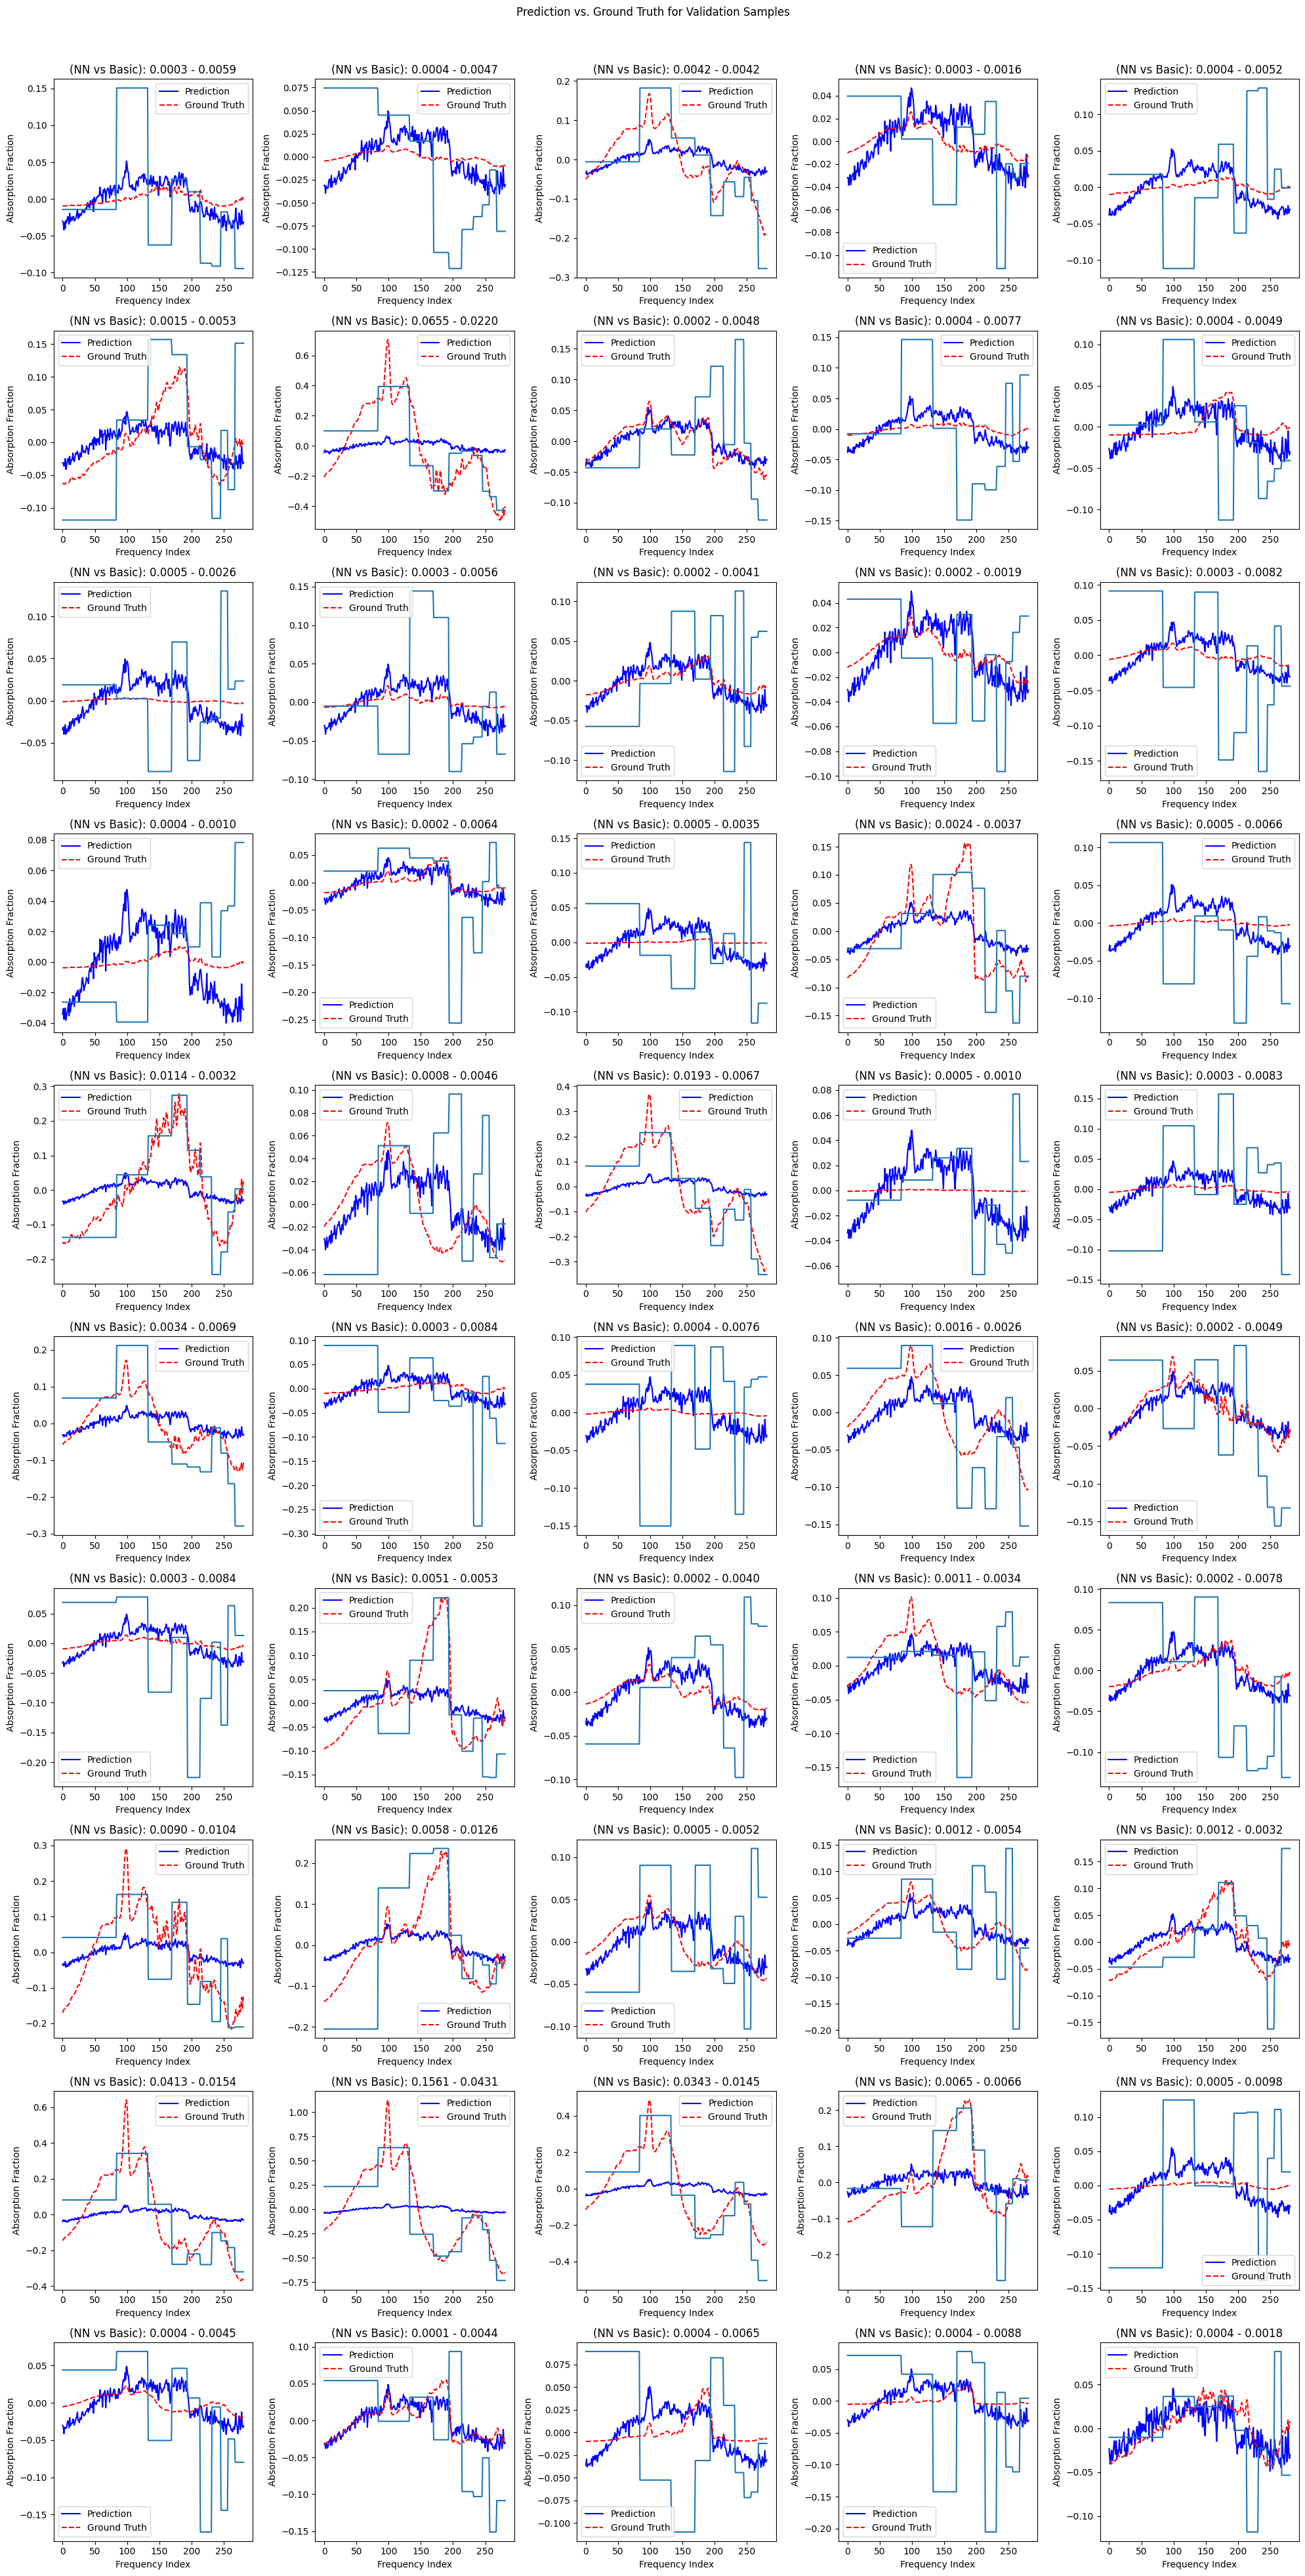

In [262]:
fig, axs = plt.subplots(10, 5, figsize=(20, 40))
fig.suptitle("Prediction vs. Ground Truth for Validation Samples")

for idx, i in enumerate(val_indices[50:100]):
    row, col = divmod(idx, 5)
    example_clean = torch.from_numpy(normalized_lc[i:i+1]).float().to(device)
    example_raw = torch.from_numpy(normalized_airs[i:i+1]).float().to(device)
    example_psd = torch.from_numpy(normalized_psd_lc[i:i+1]).float().to(device)
    ground_truth = torch.from_numpy(norm_gt_df[i:i+1]*1000).float().to(device)

    # Run a sample prediction
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        prediction = model(example_clean, example_raw, example_psd)  #

    # Convert the prediction and ground truth to NumPy arrays for plotting
    prediction_np = prediction.cpu().numpy().flatten()
    ground_truth_np = ground_truth.cpu().numpy().flatten()

    # Plot the prediction vs. ground truth
    axs[row, col].plot(prediction_np, label="Prediction", color="blue")
    axs[row, col].plot(ground_truth_np, label="Ground Truth",
                       color="red", linestyle="dashed")
    axs[row, col].plot((basic_fit_ratio[i] - basic_fit_ratio[i].mean())*1000)
    # print(basic_fit_ratio[i].mean()*1000)
    # print(ground_truth_np)
    # axs[row, col].axhline((basic_fit_ratio[i].mean()*1000 - ground_truth_np.mean()), color="black", linewidth=0.5)

    nn_mse = ((prediction_np - ground_truth_np) ** 2).mean()
    basic_mse = (
        (basic_fit_ratio[i] - basic_fit_ratio[i].mean())*1000 - ground_truth_np) ** 2

    axs[row, col].set_title(
        f"(NN vs Basic): {nn_mse:.4f} - {basic_mse.mean():.4f}")
    axs[row, col].set_xlabel("Frequency Index")
    axs[row, col].set_ylabel("Absorption Fraction")
    # axs[row, col].set_title(f"Sample {i}")
    axs[row, col].legend()

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

0
1
3
11
18
24
27
28
30
31


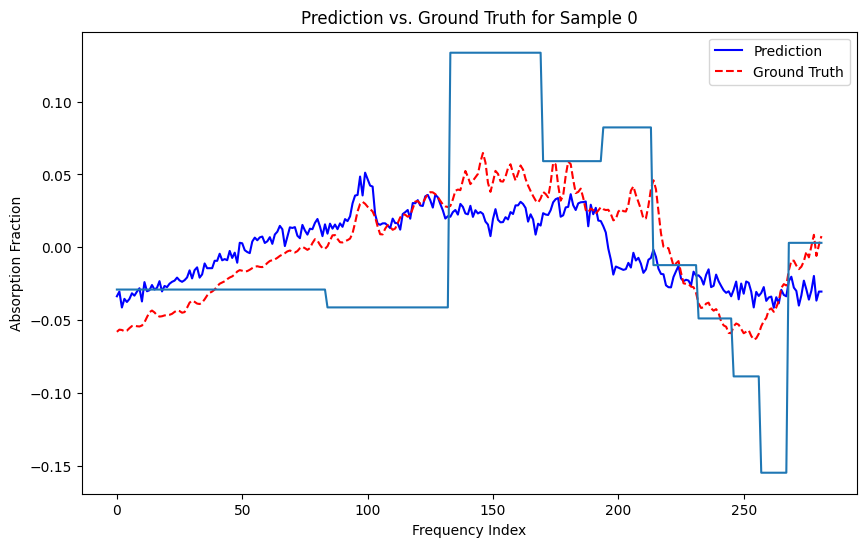

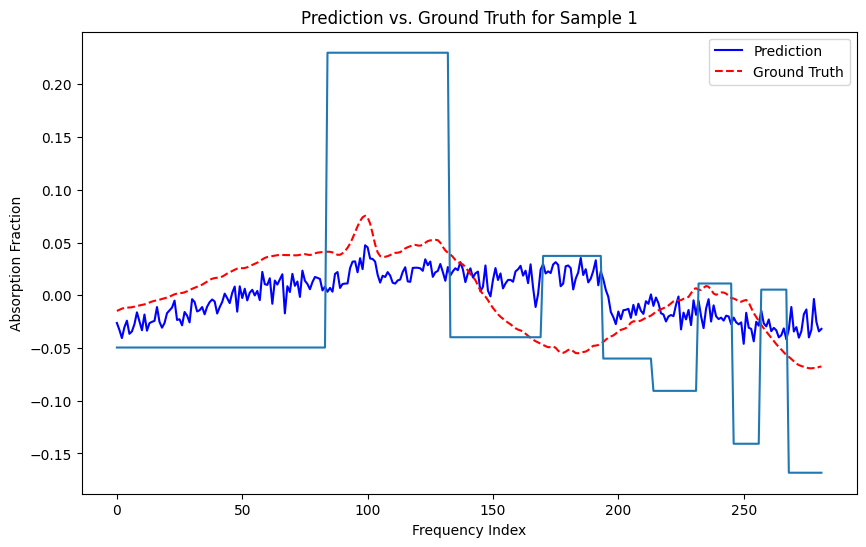

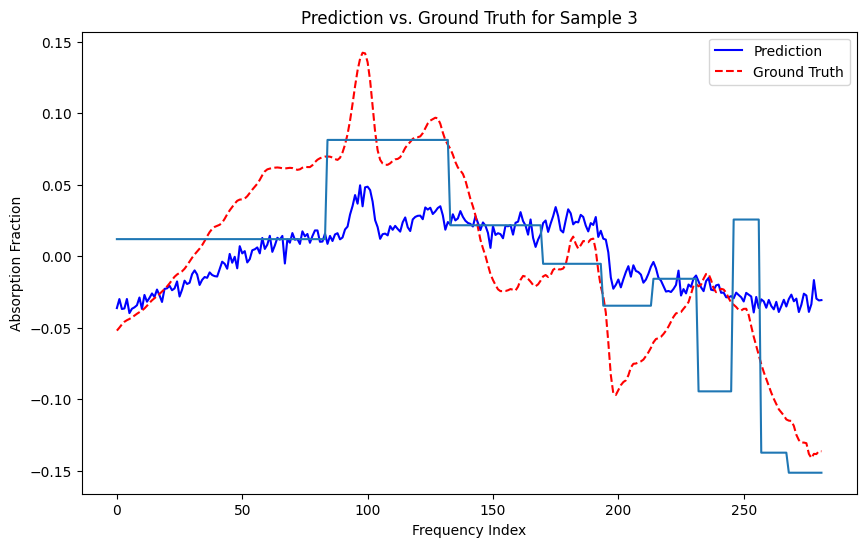

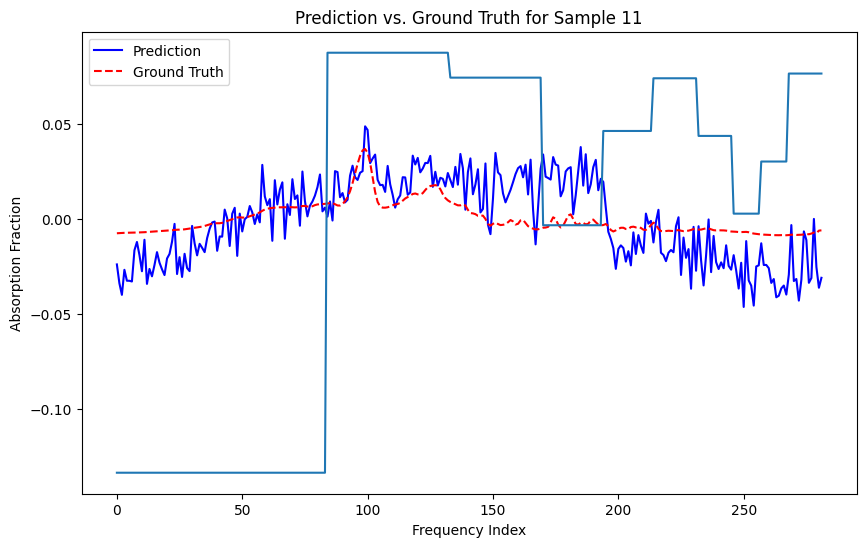

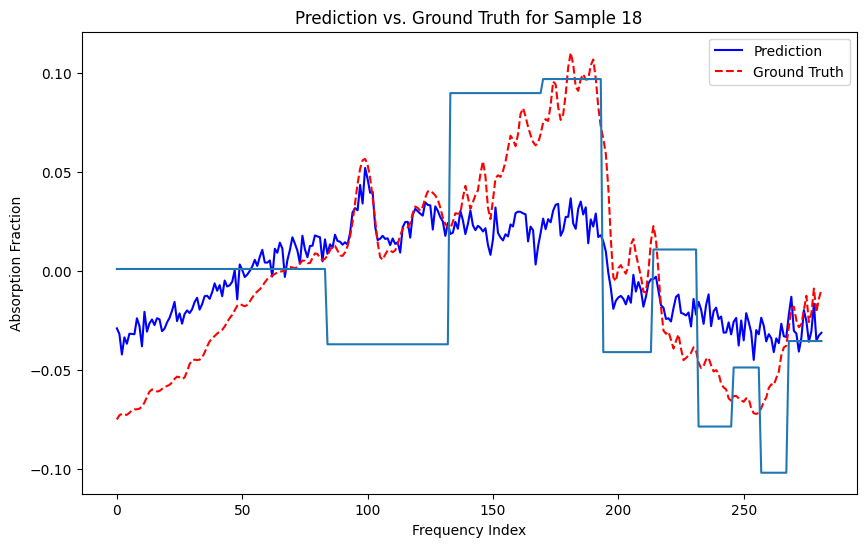

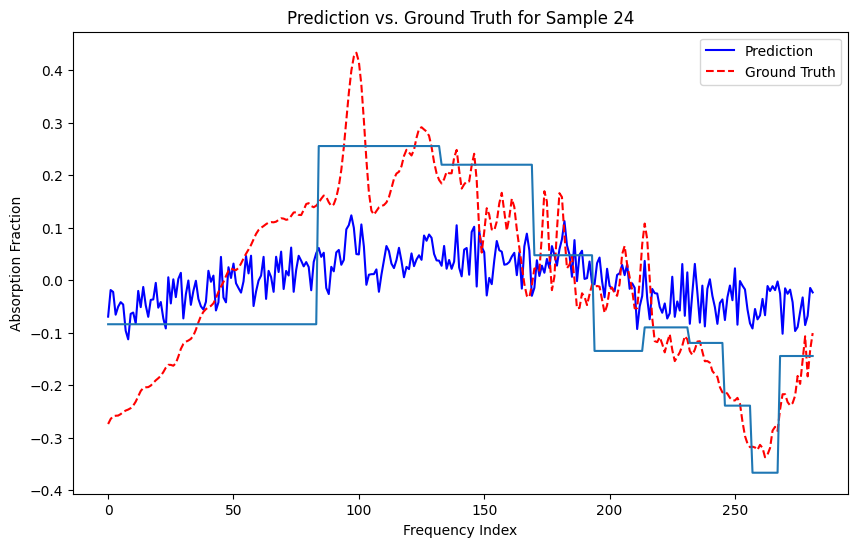

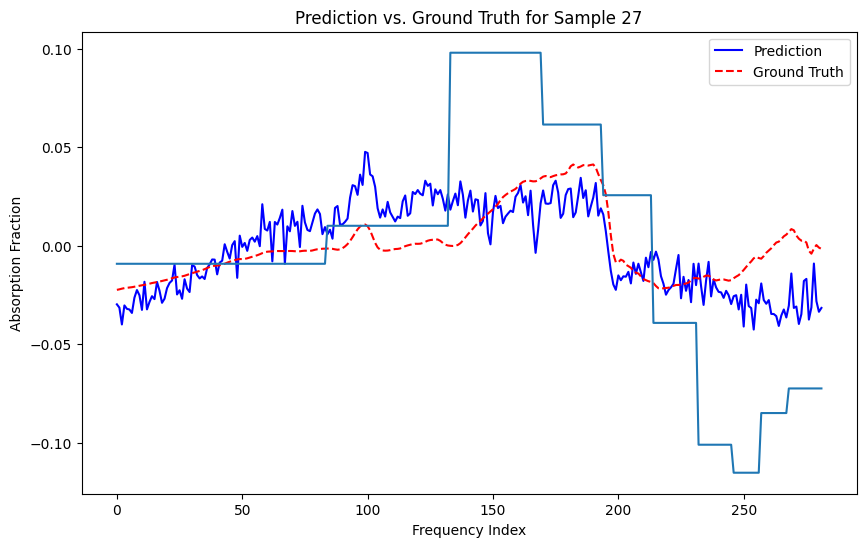

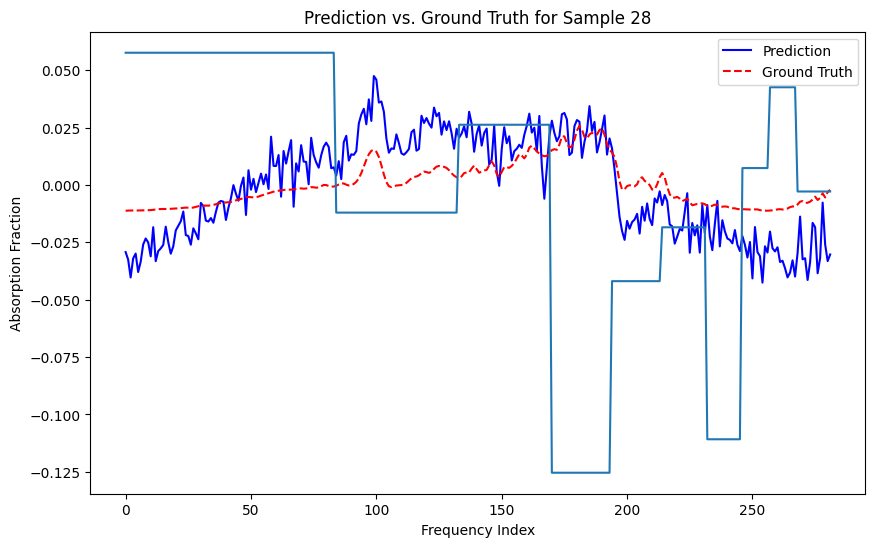

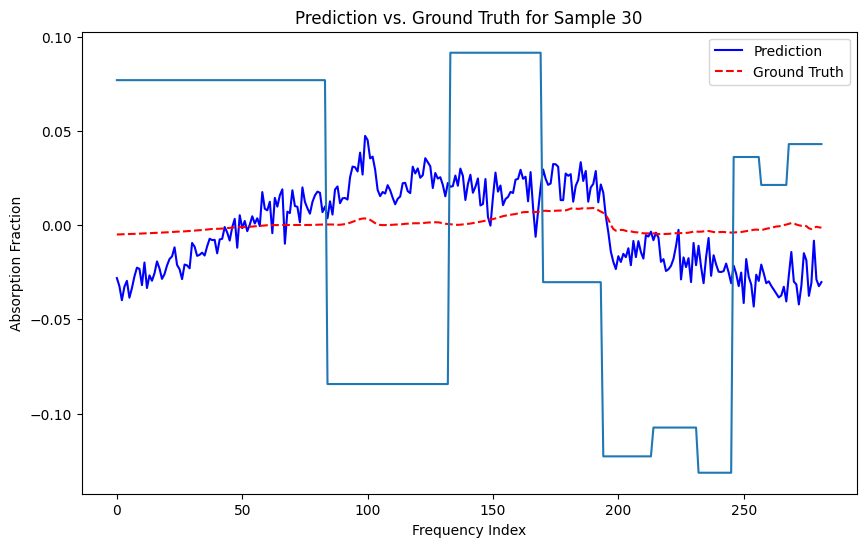

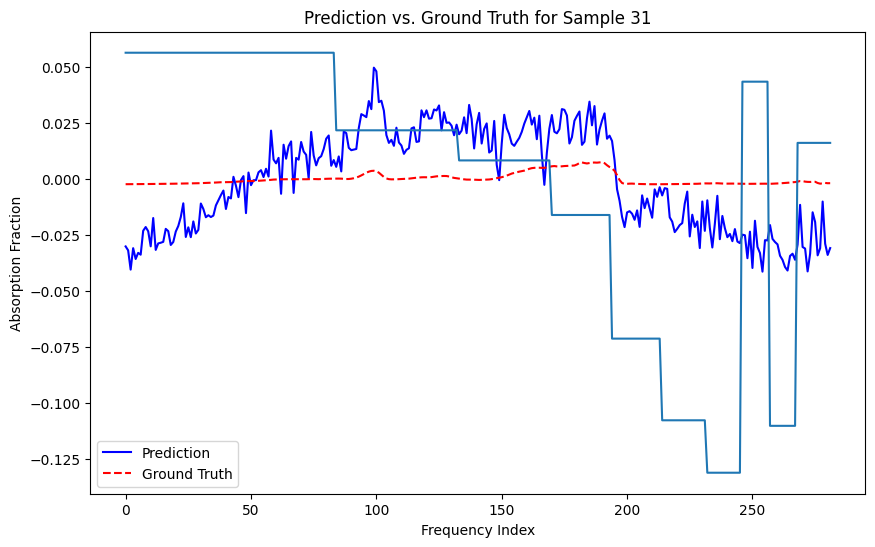

In [258]:

for i in train_indices[:10]:
    print(i)
    # Create a sample input as NumPy arrays (replace with your actual sample data)
    example_clean = torch.from_numpy(demeaned_lc[i:i+1]).float().to(device)
    example_raw = torch.from_numpy(demeaned_airs[i:i+1]).float().to(device)
    example_psd = torch.from_numpy(normalized_psd_lc[i:i+1]).float().to(device)
    # ground_truth = torch.from_numpy(gt_df[i:i+1, :-2]).float().to(device)
    ground_truth = torch.from_numpy(norm_gt_df[i:i+1]*1000).float().to(device)

    # Run a sample prediction
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        prediction = model(example_clean, example_raw, example_psd)

    # Convert the prediction and ground truth to NumPy arrays for plotting
    prediction_np = prediction.cpu().numpy().flatten()
    ground_truth_np = ground_truth.cpu().numpy().flatten()

    # Plot the prediction vs. ground truth
    plt.figure(figsize=(10, 6))
    plt.plot(prediction_np, label="Prediction", color="blue")
    plt.plot(ground_truth_np, label="Ground Truth",
             color="red", linestyle="dashed")
    plt.plot((basic_fit_ratio[i] - basic_fit_ratio[i].mean())*1000)
    # plt.axhline(basic_fit_ratio[i].mean()*1000, color='black')
    plt.xlabel("Frequency Index")
    plt.ylabel("Absorption Fraction")
    plt.title(f"Prediction vs. Ground Truth for Sample {i}")
    plt.legend()
    # plt.show()

Data Input Visualizations ---------->

In [81]:
sigmas = np.load("../outputs/results/basic_fit/sigmas_single.npy")
wc_phases = np.load("../outputs/results/basic_fit/wc_phases.npy")

In [82]:
# we will use the below very promising features
# the demmeaned_wc and demeaned_lc, and the psd_lc

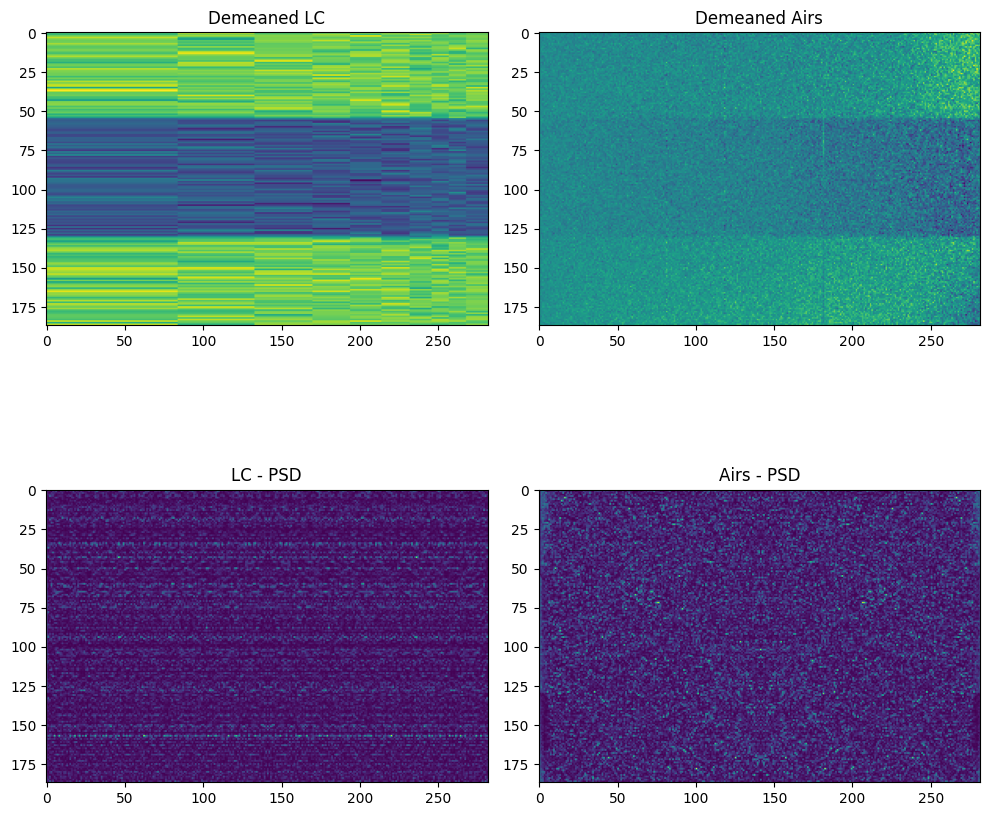

In [27]:
# Input data
observation_index = 100

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot the first image
axs[0, 0].imshow(demeaned_lc[observation_index])
axs[0, 0].set_title("Demeaned LC")

# Plot the second image
axs[0, 1].imshow(demeaned_airs[observation_index])
axs[0, 1].set_title("Demeaned Airs")

# Plot the third image
axs[1, 0].imshow(normalized_psd_lc[observation_index])
axs[1, 0].set_title("LC - PSD")

# Plot the fourth image
axs[1, 1].imshow(normalized_psd_airs[observation_index])
axs[1, 1].set_title("Airs - PSD")

plt.tight_layout()
plt.show()

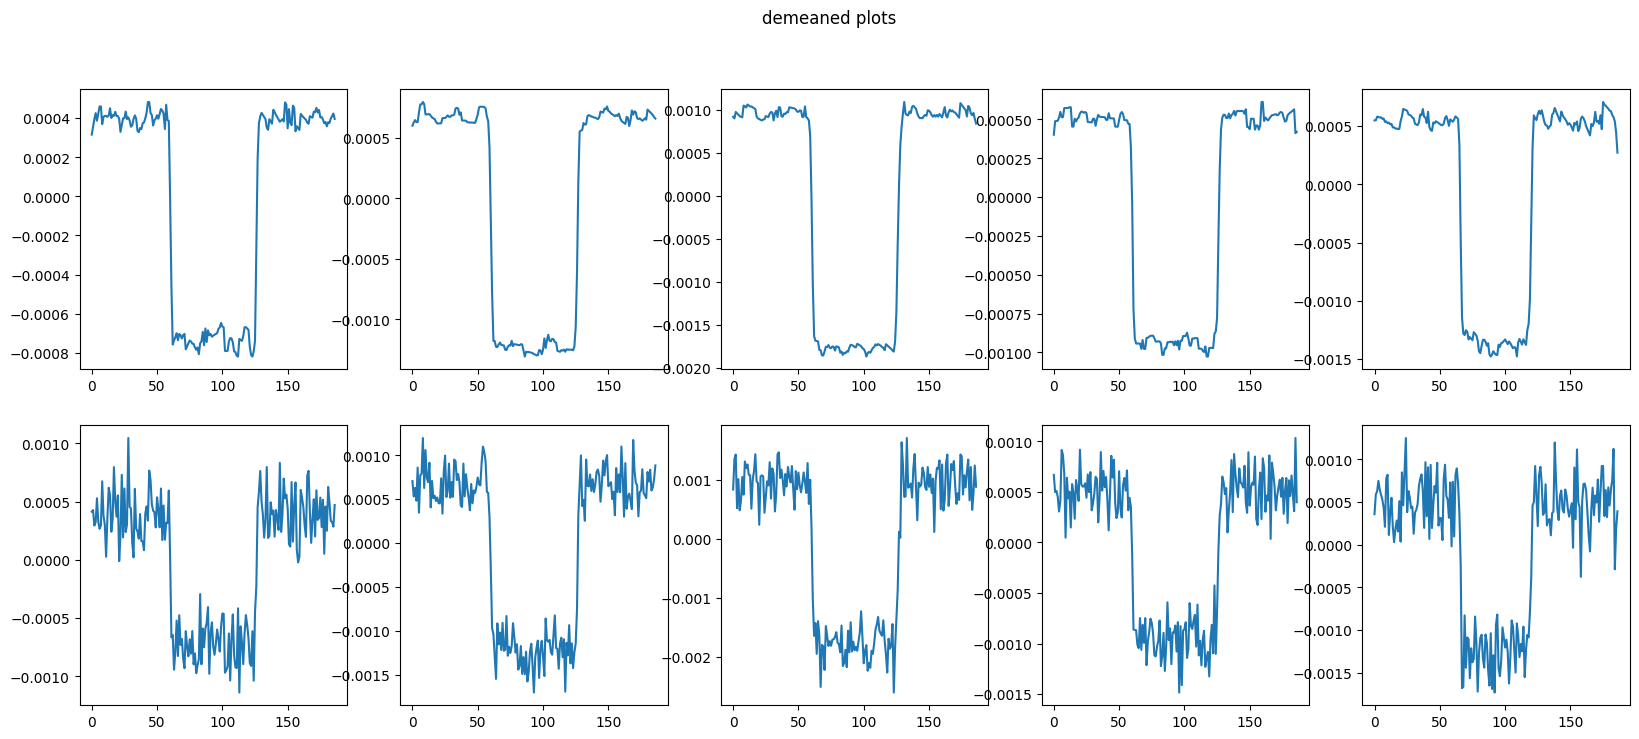

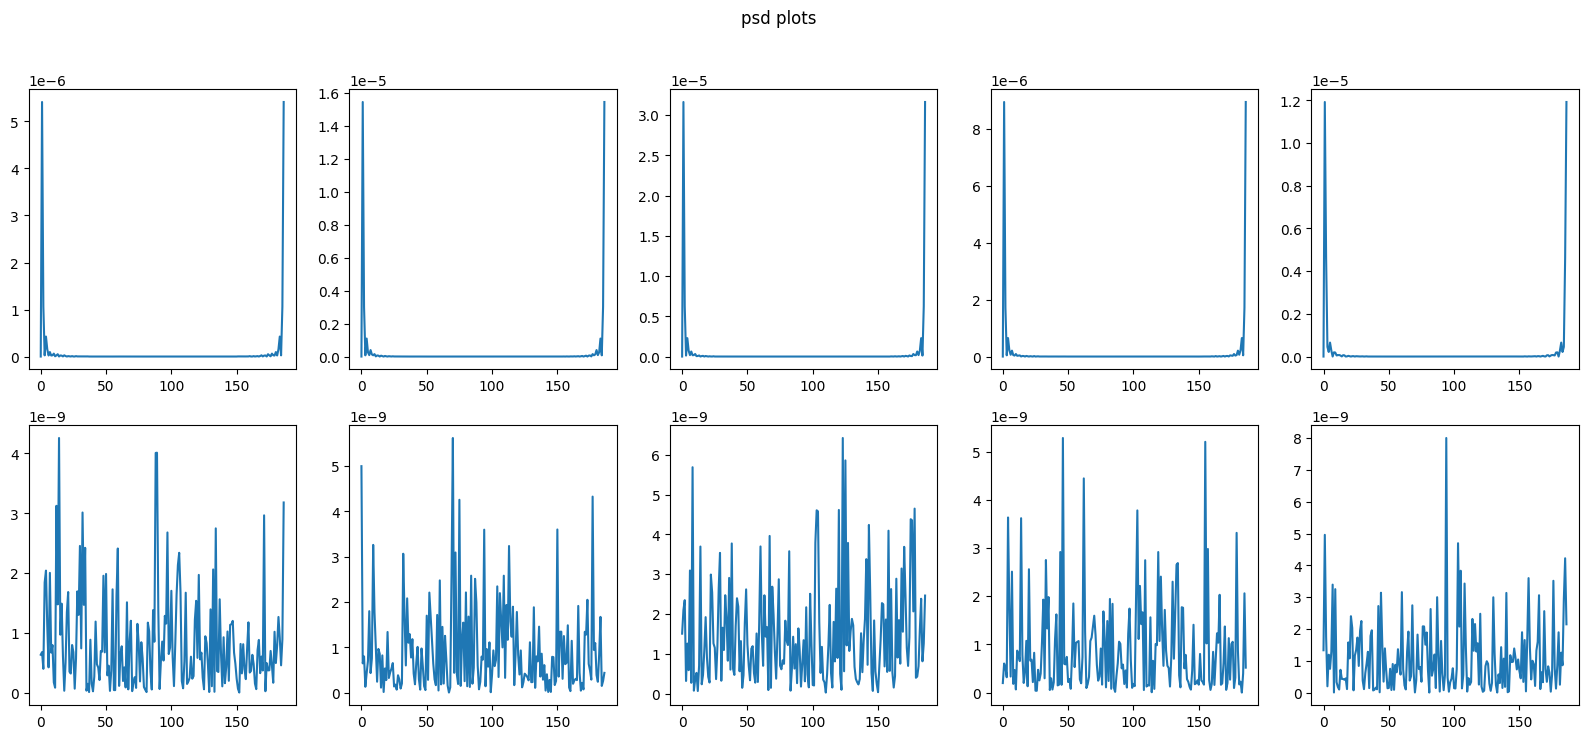

In [163]:
# Given that the demenaed wc has very boring PSD, we should ignore it for fear of overfitting noise
freq_selected = 10
psd_wc = compute_spectral_density(demeaned_wc)  # we shall skip this

fig, axs = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle("demeaned plots")
for i in range(5):
    axs[0, i].plot(demeaned_wc[i])

for i in range(5):
    axs[1, i].plot(demeaned_lc[i][:, freq_selected])
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

fig.suptitle("psd plots")
freq_selected = 50
for i in range(5):
    axs[0, i].plot(psd_wc[i])

for i in range(5):
    axs[1, i].plot(psd_lc[i][:, freq_selected])

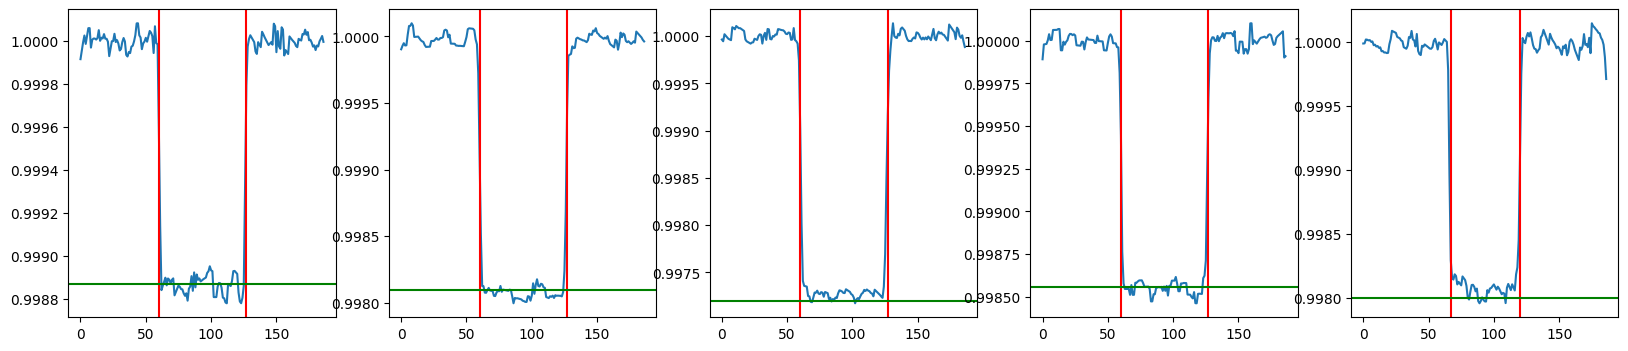

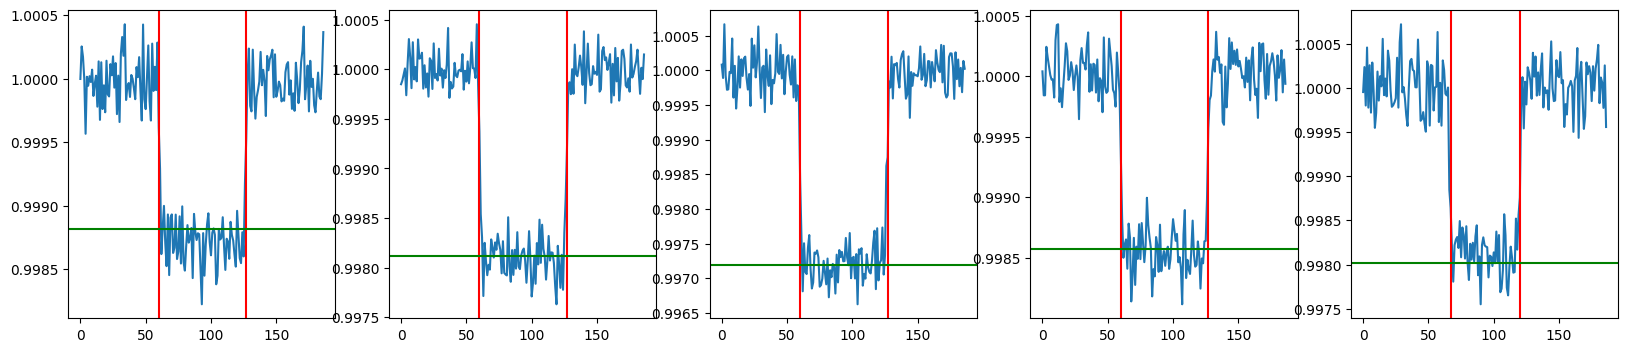

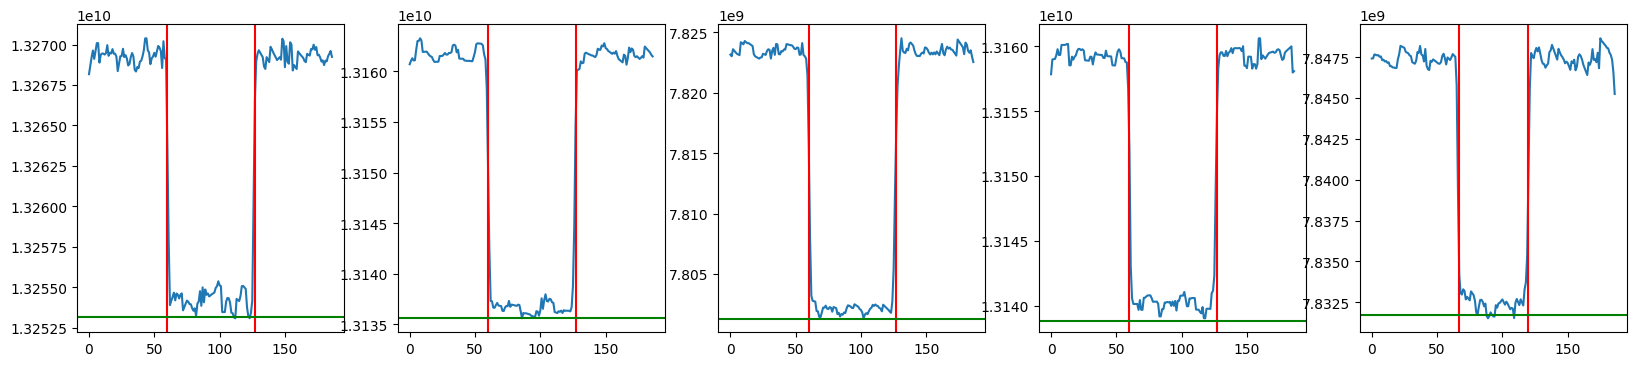

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(20, 4))

for i in range(5):
    axs[i].plot(normalized_wc[i])
    axs[i].axvline(wc_phases[i][0], color="r")
    axs[i].axvline(wc_phases[i][1], color="r")
    axs[i].axhline((1 - gt_df.iloc[i, :-2].mean()), color="g")
plt.show()

fig, axs = plt.subplots(1, 5, figsize=(20, 4))

freq_selected = 150
for i in range(5):
    axs[i].plot(normalized_lc[i][:, freq_selected])
    axs[i].axvline(wc_phases[i][0], color="r")
    axs[i].axvline(wc_phases[i][1], color="r")
    axs[i].axhline((1 - gt_df.iloc[i, freq_selected + 1].mean()), color="g")
plt.show()

fig, axs = plt.subplots(1, 5, figsize=(20, 4))

for i in range(5):
    axs[i].plot(fitted_wc[i])
    axs[i].axvline(wc_phases[i][0], color="r")
    axs[i].axvline(wc_phases[i][1], color="r")
    axs[i].axhline((1 - gt_df.iloc[i, :-2].mean())
                   * fitted_wc[i][0], color="g")
plt.show()